## Multi-label hotel room name classification

In [1]:
# uncomment the following if the environment is missing any of the dependencies
# !pip install tensorflow-hub
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import datetime, os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# uncomment next line to enable eager execution
# tf.enable_eager_execution()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

W0530 23:40:17.493144 10852 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Version:  1.13.1
Eager mode:  False
Hub version:  0.3.0
GPU is NOT AVAILABLE


### Step 1. Loading the dataset

We need to load the dataset used by this project

1. Define the functions used to load the csv data

In [2]:
def load_project_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="source_data_labeled.zip", 
      origin="https://github.com/x-wing/room-classify/raw/master/source_data_labeled.zip", 
      cache_subdir='data',
      extract=True,
      cache_dir="./")
  
  df_data = \
     pd.read_csv(dataset, usecols=['hotel id', 'room_name','labels'], \
                 dtype= { "hotel_id":np.uint8, "room_name": np.character,'labels':np.character})

  return df_data

def split_datasets(data, test_size=0.2):
    return train_test_split(data, test_size, shuffle=true)

def split_datasets_with_labels(x, y, t_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=t_size, shuffle=True)
    return x_train, x_test, y_train, y_test


2. Invoke the functoin to load the source dataset from github repo
3. Use a sample 30% (429621 records) of the whole dataset to reduce the time to run the overall project. It could take hours to finish one epoch if go with the whole dataset

In [3]:
data_df = load_project_datasets()
data_df = data_df.sample(frac=0.30)
data_df.head()

,hotel id,room_name,labels
17807,9,Imperial Suite - Free Internet In Room NRF,rtf_nrf rmf_free_internet rmt_suite rtf_free_t...
972671,105,Studio Executive,rmt_studio rtf_free_transport rmt_title
375537,254,1 King Mobility/Hearing Access Bathtub Suite N...,rmf_no_smoking rmf_accessible bdc_1 bdt_king r...
67262,113,"King nonsmoking Breakfast Buffet,",rmf_no_smoking prmf_free_breakfast bdc_1 bdt_king
1129278,37,Standard Twin - Smoking,rmf_smoking bdc_1 bdt_twin rtf_free_transport ...


In [4]:
data_df.shape

(429621, 3)

### Step 2. Data preparation

We need to use the loaded dataset to extract labels to be used for the project

1. Find all the labels

In [5]:
from collections import Counter
number_of_class = 200
top_labels = Counter(" ".join(data_df["labels"]).split()).most_common(number_of_class)
labels_dict = dict(top_labels)
labels = labels_dict.keys()

Run the following block to show all the labels and their percentage shares of the total records

In [6]:
total_records = data_df.size
for k, v in labels_dict.items():
    print('%s,%.3f' % (k, v/total_records)) 

rtf_free_transport,0.229
rmt_room,0.197
bdc_1,0.177
rtf_nrf,0.135
rmf_free_internet,0.117
prmf_free_breakfast,0.110
rmt_title,0.106
rmf_no_smoking,0.106
bdt_king,0.095
rmt_suite,0.067
bdt_double,0.058
bdc_2,0.058
bdt_queen,0.058
rmf_accessible,0.038
rmt_standard,0.036
rmf_frig,0.030
bdt_twin,0.030
rmt_deluxe,0.029
rmt_bedroom,0.028
rmf_microwave,0.025
rmt_studio,0.020
rmt_superior,0.019
rmc_1,0.017
rmf_extra_bedding,0.016
rmv_good,0.014
rmf_smoking,0.011
rmt_apartment,0.011
rmc_2,0.009
rmf_full_kitchen,0.009
rmt_triple,0.009
rmv_better,0.008
rmt_premium,0.007
rmf_balcony,0.007
rmv_standard,0.006
prmf_half_board,0.006
rmt_quadruple,0.004
rmt_villa,0.004
rmv_best,0.003
bdc_3,0.003
bdt_single,0.003
rmf_kitchenette,0.003
bdc_more,0.002
prmf_welcome_item,0.002
rmc_3,0.002
rmf_terrace,0.002
rml_pool_spa_access,0.002
prmf_all_inclusive,0.002
rmt_residence,0.002
prmf_full_board,0.002
rml_hiflr,0.001
bdt_full,0.001
rml_direct_access,0.001
rml_special_space_access,0.001
rmt_bungalow,0.001
rmt_co

2. Update and run the following if need to specify labels to be used otherwise skip this step to use default top 10 labels

In [7]:
selected_labels = [ 
    'rmt_title', 'rmt_suite', 'rmt_standard', 'rmt_deluxe','rmt_bedroom','rmt_studio','rmt_superior','rmt_apartment','rmt_triple','rmt_premium','rmt_quadruple','rmt_villa','rmt_bungalow','rmt_cottage','rmt_single','rmt_dorm',
    'rmt_non_suite', 'rmt_residence', 'rmt_room',
    'bdt_king', 'bdt_double', 'bdt_queen', 'bdt_twin','bdt_single','bdt_full',
    'bdc_more', 'rmc_more',
    'prmf_free_breakfast','prmf_half_board','prmf_welcome_item','prmf_all_inclusive','prmf_full_board','prmf_free_dinner',
    'rtf_other_item_or_credit_included','rtf_fee_included','rtf_free_parking',
    'rmf_no_smoking','rmf_accessible','rmf_extra_bedding','rmf_smoking','rmf_balcony','rmf_terrace',
    'rmv_good','rmv_better','rmv_standard','rmv_best','rmv_non']

use_selected_labels = True
['%s,%d,%.3f' % (k, labels_dict.get(k), labels_dict.get(k)/1432071) for k in selected_labels]

['rmt_title,137195,0.096',
 'rmt_suite,86330,0.060',
 'rmt_standard,45964,0.032',
 'rmt_deluxe,38012,0.027',
 'rmt_bedroom,36536,0.026',
 'rmt_studio,26221,0.018',
 'rmt_superior,25103,0.018',
 'rmt_apartment,14303,0.010',
 'rmt_triple,11242,0.008',
 'rmt_premium,8399,0.006',
 'rmt_quadruple,4967,0.003',
 'rmt_villa,4935,0.003',
 'rmt_bungalow,1467,0.001',
 'rmt_cottage,1338,0.001',
 'rmt_single,514,0.000',
 'rmt_dorm,515,0.000',
 'rmt_non_suite,64,0.000',
 'rmt_residence,2167,0.002',
 'rmt_room,253629,0.177',
 'bdt_king,123045,0.086',
 'bdt_double,75354,0.053',
 'bdt_queen,74821,0.052',
 'bdt_twin,38324,0.027',
 'bdt_single,3543,0.002',
 'bdt_full,1838,0.001',
 'bdc_more,2921,0.002',
 'rmc_more,570,0.000',
 'prmf_free_breakfast,142241,0.099',
 'prmf_half_board,7099,0.005',
 'prmf_welcome_item,2724,0.002',
 'prmf_all_inclusive,2351,0.002',
 'prmf_full_board,2040,0.001',
 'prmf_free_dinner,818,0.001',
 'rtf_other_item_or_credit_included,1033,0.001',
 'rtf_fee_included,932,0.001',
 'rtf_

In [8]:
print(list(labels))

['rtf_free_transport', 'rmt_room', 'bdc_1', 'rtf_nrf', 'rmf_free_internet', 'prmf_free_breakfast', 'rmt_title', 'rmf_no_smoking', 'bdt_king', 'rmt_suite', 'bdt_double', 'bdc_2', 'bdt_queen', 'rmf_accessible', 'rmt_standard', 'rmf_frig', 'bdt_twin', 'rmt_deluxe', 'rmt_bedroom', 'rmf_microwave', 'rmt_studio', 'rmt_superior', 'rmc_1', 'rmf_extra_bedding', 'rmv_good', 'rmf_smoking', 'rmt_apartment', 'rmc_2', 'rmf_full_kitchen', 'rmt_triple', 'rmv_better', 'rmt_premium', 'rmf_balcony', 'rmv_standard', 'prmf_half_board', 'rmt_quadruple', 'rmt_villa', 'rmv_best', 'bdc_3', 'bdt_single', 'rmf_kitchenette', 'bdc_more', 'prmf_welcome_item', 'rmc_3', 'rmf_terrace', 'rml_pool_spa_access', 'prmf_all_inclusive', 'rmt_residence', 'prmf_full_board', 'rml_hiflr', 'bdt_full', 'rml_direct_access', 'rml_special_space_access', 'rmt_bungalow', 'rmt_cottage', 'rtf_other_item_or_credit_included', 'rmf_traditional', 'rtf_fee_included', 'rml_loflr', 'prmf_free_dinner', 'rmf_mini_frig', 'rmc_more', 'rtf_free_park

In [9]:
if use_selected_labels==True:
    active_labels = selected_labels
    number_of_class = len(selected_labels)
else:
    active_labels = list(labels)

3. Split the input data into training and testing sets

In [10]:
data_label_df = data_df["labels"].str.split()
x_train, x_test, y_train, y_test = split_datasets_with_labels(data_df, data_label_df, 0.45)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(236291, 3) (193330, 3) (236291,) (193330,)


In [11]:
# show first ten room names in training sets
x_train['room_name'].head(10)

852570                                      Large Twin Room 
98211      1 King Bed Non-Smoking - Free Internet In Room...
1055392    Double Room,Pool View (2 people) Breakfast Buf...
62094                            King Executive Deluxe Room 
1248001    Oversized Suite with 1 King Bed and Sofabed - ...
958409     1 Queen Hearing Accessible Studio Non-Smoking ...
346180                        Twin Room - Non-refundable NRF
856803                           TWO QUEEN BEDS NONSMOKE NRF
199975     1 King Bed Accessible Room Non-Smoking - Free ...
13427      Guest room,2 Queen,Courtyard view - Free Parki...
Name: room_name, dtype: object

4. Use MultiLabelBinarizer to encode labels into zeros and ones

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

encoder = MultiLabelBinarizer(active_labels)
encoder.fit_transform(y_train)
train_encoded = encoder.transform(y_train)
test_encoded = encoder.transform(y_test)
num_classes = len(encoder.classes_)

# Print all possible genres and the labels for the first movie in our training dataset
# print(encoder.classes_)
# print(train_encoded[0])

D:\Python\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['bdc_1', 'bdc_2', 'bdc_3', 'bdt_capsule', 'bdt_sofabed', 'prmf_breakfast_credit', 'prmf_free_lunch', 'prmf_promotional', 'rmc_1', 'rmc_2', 'rmc_3', 'rmf_allergy_friendly', 'rmf_free_internet', 'rmf_frig', 'rmf_full_kitchen', 'rmf_kitchenette', 'rmf_microwave', 'rmf_mini_frig', 'rmf_no_ac', 'rmf_pet_friendly', 'rmf_pet_not_allow', 'rmf_traditional', 'rml_annex_building', 'rml_concierge_level', 'rml_direct_access', 'rml_garden_area', 'rml_hiflr', 'rml_lmited_or_no_access', 'rml_loflr', 'rml_loft', 'rml_outdoor_access', 'rml_pool_spa_access', 'rml_special_access', 'rml_special_flr', 'rml_special_space_access', 'rml_tower', 'rmt_cabin', 'rmt_mini', 'rmt_parlor', 'rmt_pod', 'rtf_acctivity_included', 'rtf_free_transport', 'rtf_nrf'] will be ignored
  .format(sorted(unknown, key=str)))
D:\Python\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\preprocessing\label.py:935: UserWa

5. change encoded labels into string type as required by the model later on

In [13]:
train_encoded_f = train_encoded.astype(np.str)
test_encoded_f = test_encoded.astype(np.str)

### Step 3. Model setup

Next, we need to specify tfhub module for encoding. Our final choice is universal-sentence-encoder (See in [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/2)). Uncomment corresponding line to switch to random-nnlm-en-dim128 module  

1. Create hub module
2. Define embedding function to be used in Lambda express for input processing
3. Create keras model
4. Compile model with an optimizer (use tf.train.AdamOptimizer or tf.keras.optimizers.Adam), loss function, metrics


In [16]:
# module_url = "https://tfhub.dev/google/random-nnlm-en-dim128/1"
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url, trainable=False)
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

# Example: uncomment to see the results of the embedding
# embeddings = embed([
#     "King Accessible Tub Sofabed Non-Smoking - Free Internet In Room - Free Parking NRF",
#     "Deluxe Room, 2 Double Beds, High Roller View Food/Beverage Credit"])

# with tf.Session() as session:
#   session.run([tf.global_variables_initializer(), tf.tables_initializer()])
#   message_embeddings = session.run(embed(messages))
# print(message_embeddings)

512

In [17]:
def embedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
hub_layer = tf.keras.layers.Lambda(embedding, output_shape=(embed_size,))(input_text)
dense = tf.keras.layers.Dense(256, activation='relu')(hub_layer)
pred = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=[input_text], outputs=pred)

# prefer this way yet get it to work with the input
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(embed_size, input_shape=(1,)))
# model.add(tf.keras.layers.Lambda(lambda x: UniversalEmbedding(x), output_shape=(embed_size,)))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0530 23:50:13.060794 10852 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda (Lambda)              (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 47)                12079     
Total params: 143,407
Trainable params: 143,407
Non-trainable params: 0
_________________________________________________________________


In [18]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'binary_accuracy' categorical_accuracy
# adam = tf.keras.optimizers.Adam(lr=0.05, beta_1=0.99, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
adam =tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.99, beta2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['categorical_accuracy','binary_accuracy'])

### Step 4. Run Model

Here, we can run the model by loading previous weights with specified epochs and batch size. If need to save the model or the weights for the run, please uncomment the corresponding lines.

In [19]:
with tf.Session() as session:
  tf.keras.backend.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model_encoder.weights')
  history = model.fit(x_train['room_name'].values, 
            train_encoded_f,
            validation_data=(x_test['room_name'].values, test_encoded_f),
            epochs=50,
            batch_size=128)
  
  results = model.evaluate(x_test['room_name'].values, test_encoded_f)

  model.save_weights('./model_encoder.weights')
  model.save('saved_model_encoder.h5')  

#   model.save_weights('./model_encoder_a.model')
#   model.save('model_encoder.h5') 
#   model_encoder_c is the new base

236291/236291 [==============================] - 89s 376us/sample - loss: 0.0140 - categorical_accuracy: 0.3873 - binary_accuracy: 0.9955 - val_loss: 0.0176 - val_categorical_accuracy: 0.3883 - val_binary_accuracy: 0.9945
Epoch 40/50
236291/236291 [==============================] - 87s 367us/sample - loss: 0.0139 - categorical_accuracy: 0.3879 - binary_accuracy: 0.9955 - val_loss: 0.0176 - val_categorical_accuracy: 0.3863 - val_binary_accuracy: 0.9945
Epoch 41/50
236291/236291 [==============================] - 87s 369us/sample - loss: 0.0139 - categorical_accuracy: 0.3869 - binary_accuracy: 0.9955 - val_loss: 0.0176 - val_categorical_accuracy: 0.3843 - val_binary_accuracy: 0.9945
Epoch 42/50
236291/236291 [==============================] - 87s 368us/sample - loss: 0.0139 - categorical_accuracy: 0.3887 - binary_accuracy: 0.9955 - val_loss: 0.0176 - val_categorical_accuracy: 0.3863 - val_binary_accuracy: 0.9945
Epoch 43/50
236291/236291 [==============================] - 89s 377us/sampl

W0531 01:10:32.732378 10852 deprecation.py:323] From D:\Python\Anaconda3\envs\tf_cpu\lib\site-packages\tensorflow\python\keras\engine\network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


W0531 01:10:35.321220 10852 saving.py:116] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


In [20]:
# Uncomment next line if need to remove the tmp directory
# !rm -rf ./tmp
print(results)

[0.017826246832596798, 0.39383954, 0.9944263]


In [21]:
# Uncomment to show how the CategoricalAccuracy works but this requires earger execution enabled
# mm = tf.keras.metrics.CategoricalAccuracy()
# tlabels = [[1, 0, 0, 1],[0, 1, 1, 1],[1, 1, 0, 0],[0, 0, 0, 1],[1, 1, 0, 0]]
# tpreds =  [[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
# mm.update_state(tlabels, tpreds)
# print('Final result: ', mm.result().numpy())

In [22]:
# show the history keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'binary_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_binary_accuracy'])

### Step 5. Model results

1. Training and validation loss


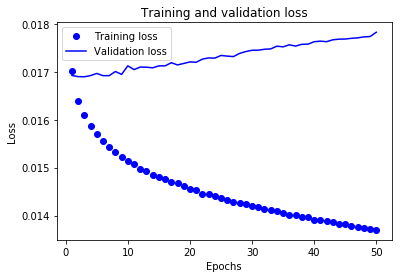

In [23]:
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2. Training and validation acccuracy

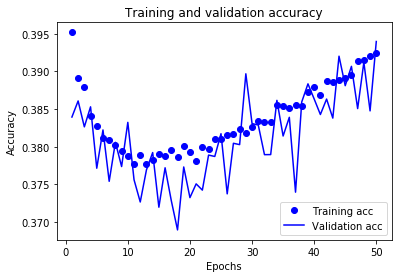

In [24]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3. Load and run saved model to ROC curve for selected labels

In [25]:
# del model
#saved_model = 'model_f1_encoder.h5'
#saved_model = '.\models\model_encoder_high_lrt.h5'
#saved_model = '.\models\model_encoder_nlm.h5'
saved_model = '.\models\model_encoder_final.h5'

with tf.Session() as session:
  tf.keras.backend.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model = tf.keras.models.load_model(saved_model)
  adam =tf.train.AdamOptimizer(learning_rate=0.003, beta1=0.99, beta2=0.999, epsilon=1e-07)
  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['categorical_accuracy','binary_accuracy'])
  results = model.evaluate(x_test['room_name'].values, test_encoded_f)
  y_pred = model.predict(x_test['room_name'].values)
  print(results)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0531 01:14:47.366496 10852 saver.py:1483] Saver not created because there are no variables in the graph to restore


W0531 01:14:54.796551 10852 saving.py:243] No training configuration found in save file: the model was *not* compiled. Compile it manually.


193330/193330 [==============================] - 56s 291us/sample - loss: 0.0192 - categorical_accuracy: 0.4188 - binary_accuracy: 0.9941
[0.019152621149239085, 0.41878653, 0.9941495]


In [27]:
y_score = y_pred > 0.50
y_score = y_score.astype(np.int)
y_test = test_encoded_f=='1'
y_test = y_test.astype(np.int)
print(y_test.shape, y_score[:,1], y_test[:,1])

(193330, 47) [0 1 0 ... 0 0 0] [0 1 0 ... 0 0 0]


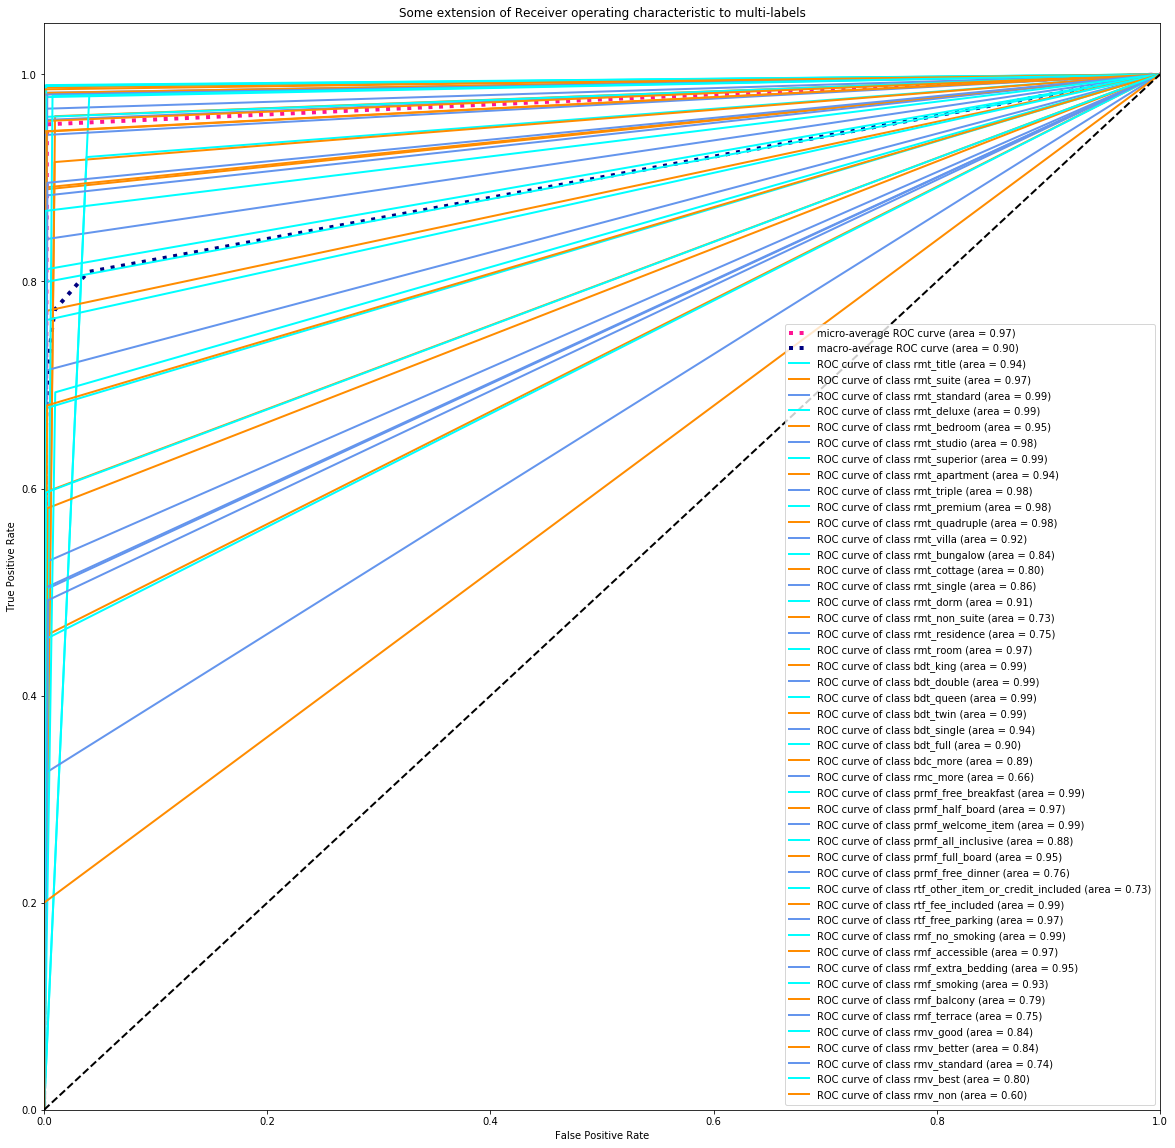

In [28]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
plt.figure(figsize = (20,20))

# Compute ROC curve and ROC area for each class
n_classes = len(encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-labels')
plt.legend(loc="lower right")
plt.show()
# uncomment if need to save the image to a drive
# plt.savefig('./images/final_roc_curve4.png', bbox_inches='tight')


# Uncomment all the following block if need to Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-labels')
# plt.legend(loc="lower right")
# plt.show()

In [30]:
# print out label count, share and roc_auc
for i in range(n_classes):
    lkey = encoder.classes_[i]
    lcount = labels_dict.get(lkey)
    print("%s,%d,%.3f,%.3f" % (lkey, lcount, lcount/1432071, roc_auc[i]))

rmt_title,137195,0.096,0.941
rmt_suite,86330,0.060,0.975
rmt_standard,45964,0.032,0.991
rmt_deluxe,38012,0.027,0.989
rmt_bedroom,36536,0.026,0.953
rmt_studio,26221,0.018,0.977
rmt_superior,25103,0.018,0.994
rmt_apartment,14303,0.010,0.944
rmt_triple,11242,0.008,0.983
rmt_premium,8399,0.006,0.979
rmt_quadruple,4967,0.003,0.977
rmt_villa,4935,0.003,0.920
rmt_bungalow,1467,0.001,0.838
rmt_cottage,1338,0.001,0.798
rmt_single,514,0.000,0.857
rmt_dorm,515,0.000,0.906
rmt_non_suite,64,0.000,0.729
rmt_residence,2167,0.002,0.751
rmt_room,253629,0.177,0.970
bdt_king,123045,0.086,0.993
bdt_double,75354,0.053,0.989
bdt_queen,74821,0.052,0.994
bdt_twin,38324,0.027,0.991
bdt_single,3543,0.002,0.941
bdt_full,1838,0.001,0.899
bdc_more,2921,0.002,0.885
rmc_more,570,0.000,0.662
prmf_free_breakfast,142241,0.099,0.994
prmf_half_board,7099,0.005,0.972
prmf_welcome_item,2724,0.002,0.990
prmf_all_inclusive,2351,0.002,0.881
prmf_full_board,2040,0.001,0.945
prmf_free_dinner,818,0.001,0.764
rtf_other_item_or_cr

In [31]:
# just print out the labels shares
# for k in selected_labels:
#     print('%s,%d,%.3f' % (k, labels_dict.get(k), labels_dict.get(k)/1432071))

5. Show the model prediction in action with some example data entries

In [33]:
# raw_test = [
#     "King Accessible Tub Sofabed Non-Smoking - Free Internet In Room - Free Parking NRF", # King
#     "Deluxe Villa,6 Bedrooms,River View,Garden Area Free Parking,Free Wireless Internet,NRF", # Deluxe Villa
#     "Superior Double with Balcony NRF", # Superior, Double
#     "Wonderful King Ocean Front - Free Airport Shuttle - Non-Refundable", # King
#     "Room,1 King Bed with Sofa bed,Non Smoking,Refrigerator & Microwave,1 Full"
# ]

raw_test = [
"Deluxe Room, 2 Double Beds, Smoking",
"Deluxe Room, 2 Double Beds, Smoking Food/Beverage Credit",
"Deluxe Room, 2 Double Beds, Non Smoking, Strip View",                 
"Deluxe Room, 2 Double Beds, Non Smoking, Strip View Food/Beverage Credit",
"Deluxe Room, 2 Double Beds, High Roller View", 
"Deluxe Room, 2 Double Beds, High Roller View Food/Beverage Credit",
"Deluxe Room, 2 Queen Beds, Non Smoking",        
"Deluxe Room, 2 Queen Beds, Non Smoking Food/Beverage Credit",
"Deluxe Room, 1 King Bed, Non Smoking, High Roller View",              
"Deluxe Room, 1 King Bed, Non Smoking, High Roller View Food/Beverage Credit",
"Deluxe Room, 2 Queen Beds, High Roller View",
"Deluxe Room, 2 Queen Beds, High Roller View Food/Beverage Credit",
"Luxury Room, 1 King Bed, Non Smoking",         
"Luxury Room, 1 King Bed, Non Smoking Food/Beverage Credit",
"Luxury Room, 2 Double Beds, Non Smoking",                
"Luxury Room, 2 Double Beds, Non Smoking Food/Beverage Credit",
"Suite, 1 King Bed, Non Smoking",             
"Deluxe Bungalow, 1 King Bed, Non Smoking, Poolside",
"Deluxe Poolside Cabana, 2 Doubles, Non-Smoking"
]

raw_test2 = [
"Smoking",
"Smoking Not",
"Smoking Allowed",
"Smoking Not Allowed",
"Smoke Free",
"Free Smoking",
"Non Smoking",                 
"Non-Smoking",
"smkn", 
"non smoking",
"no smoking",
"Nonsmoking",        
"NONSMOKE",    
]



In [34]:
# del model
with tf.Session() as session:
  tf.keras.backend.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model = tf.keras.models.load_model('.\models\model_encoder_final.h5')
  results = model.predict(np.array(raw_test))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0531 01:22:54.082457 10852 saver.py:1483] Saver not created because there are no variables in the graph to restore


W0531 01:23:03.459063 10852 saving.py:243] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [36]:
# for i in range(num_classes): 
#     print(' ' + encoder.classes_[i], end=" ")  
# print('')

# print out prediction by given threshold
counter=0
threshold=0.30
for room_features in results:
  print(raw_test[counter])
  label_index = 0
  for p in room_features:
    if p > threshold :
        print(encoder.classes_[label_index] + '=' + str(round(p * 100, 2)) + '%', end=" ")
    label_index += 1
  counter += 1
  print('\n')

Deluxe Room, 2 Double Beds, Smoking
rmt_deluxe=100.0% rmt_room=100.0% bdt_double=99.75% rmf_smoking=99.99% 

Deluxe Room, 2 Double Beds, Smoking Food/Beverage Credit
rmt_deluxe=100.0% rmt_room=100.0% bdt_double=99.89% rtf_other_item_or_credit_included=99.42% rmf_smoking=72.74% 

Deluxe Room, 2 Double Beds, Non Smoking, Strip View
rmt_deluxe=99.98% rmt_room=100.0% bdt_double=99.98% 

Deluxe Room, 2 Double Beds, Non Smoking, Strip View Food/Beverage Credit
rmt_deluxe=99.96% rmt_room=100.0% bdt_double=99.99% rtf_other_item_or_credit_included=32.62% rmf_no_smoking=39.17% 

Deluxe Room, 2 Double Beds, High Roller View
rmt_title=55.62% rmt_deluxe=100.0% rmt_room=100.0% bdt_double=100.0% rmv_good=51.46% 

Deluxe Room, 2 Double Beds, High Roller View Food/Beverage Credit
rmt_title=98.09% rmt_deluxe=100.0% rmt_room=100.0% bdt_double=100.0% 

Deluxe Room, 2 Queen Beds, Non Smoking
rmt_deluxe=99.99% rmt_room=100.0% bdt_queen=100.0% rmf_no_smoking=100.0% 

Deluxe Room, 2 Queen Beds, Non Smoking Fo

### Note: if try to access saved_models folder in google drive with colab:
```
from google.colab import drive
drive.mount('/content/gdrive')
!ls -l '/content/gdrive/My Drive/saved_models'
model.save_weights('/content/gdrive/My Drive/saved_models/model_encoder.weights')
model.save('/content/gdrive/My Drive/saved_models/saved_model_encoder.h5')
```